# **Практика 5: Атака с ограниченной памятью (PGD Projected Gradient Descent)**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

 # **Цель задания:**
 Изучить одну из наиболее мощных атак на модели ИИ — атаку **Projected Gradient Descent** (**PGD**).
 Научиться использовать **PGD** для создания противоречивых примеров и оценить её влияние на обученные модели.

# **Задачи:**
1. Загрузить ранее обученную модель на датасете **MNIST**.
2. Изучить теоретические основы атаки **PGD**.
3. Реализовать атаку **PGD** с помощью фреймворка **Foolbox**.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

# **Шаги выполнения:**

## **Шаг 1: Загрузка обученной модели и данных MNIST**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0920
Test accuracy on clean images: 0.975600004196167


##**Шаг 2: Теория атаки Projected Gradient Descent (PGD)**

 Атака **Projected Gradient Descent** (**PGD**) — это расширение **FGSM** (**Fast Gradient Sign Method**), где атака выполняется итеративно. На каждой итерации добавляются небольшие изменения к входным данным в направлении увеличения ошибки модели.

 После каждой итерации результат "проецируется" на допустимое пространство для ограничивания размера изменений, что позволяет сохранять противоречивый пример в пределах определенной нормы (например, L∞).

##**Шаг 3: Реализация атаки PGD с использованием Foolbox**

 Теперь мы реализуем атаку **PGD**, используя фреймворк **Foolbox**, который упрощает запуск различных атак на модели ИИ

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00


Возьмем 10 рандомных изображений и отобразим результат атаки **PGD**

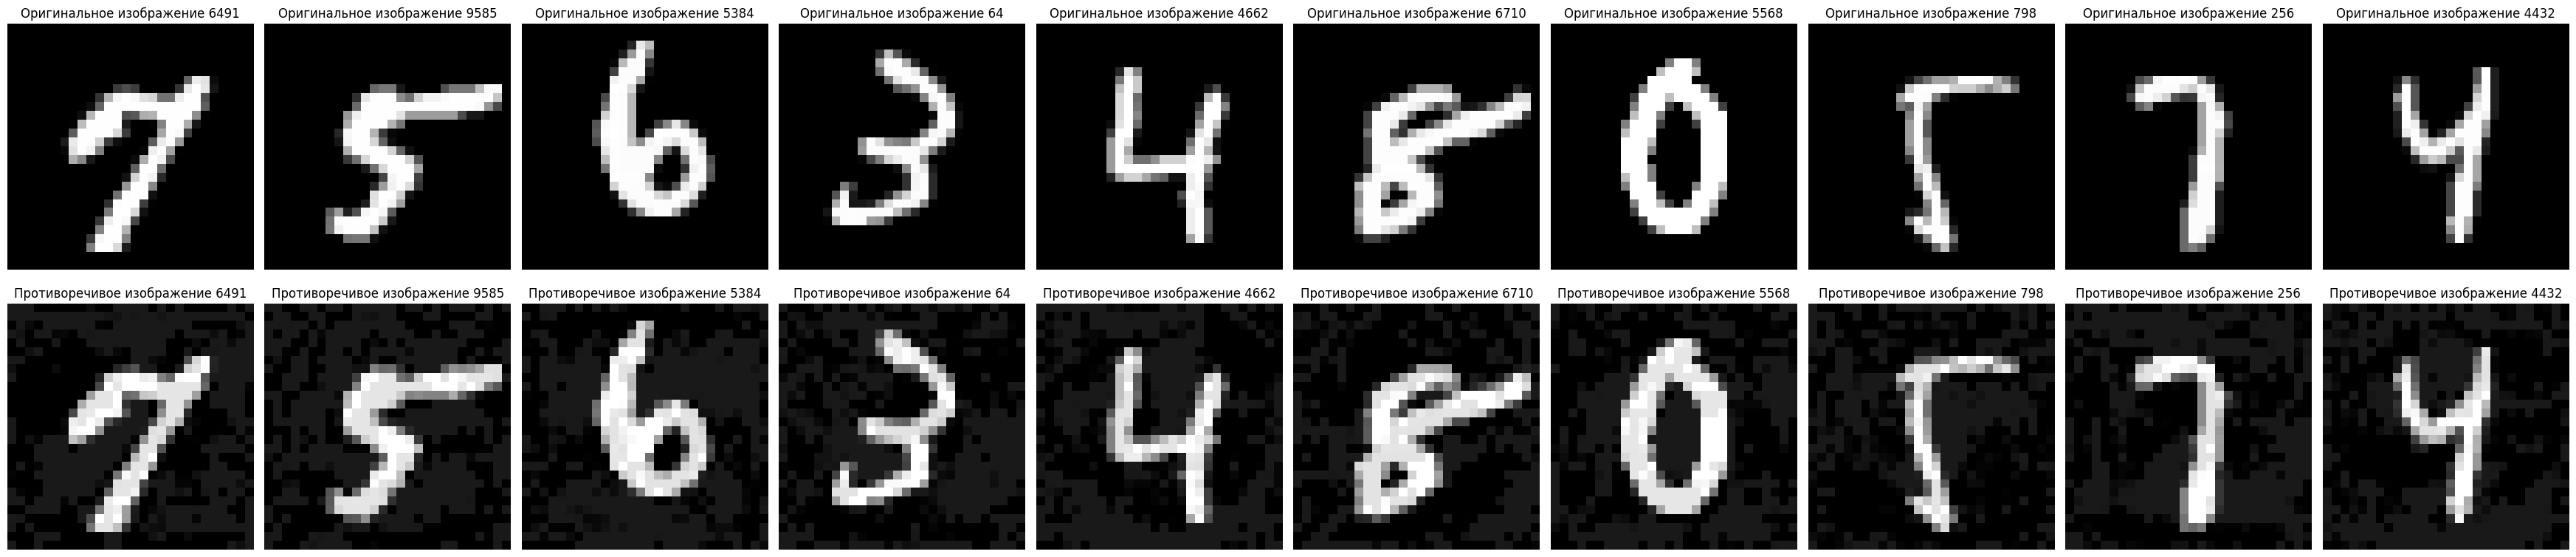

In [5]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели:
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки PGD:
attack = fb.attacks.LinfPGD()

# Количество изображений для атаки:
num_images = 10

# Случайный выбор индексов изображений:
random_indices = np.random.choice(len(test_images), num_images, replace=False)

# Создание подграфиков для отображения результатов:
plt.figure(figsize=(35, 8))

for i in range(num_images):

    # Выбор случайного изображения для атаки:
    index = random_indices[i]

    # Выбор изображения для атаки:
    image = tf.convert_to_tensor(test_images[index], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[index])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки:
    adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.1)

    # Отображение оригинального изображения:
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {index+1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    # Отображение противоречивого изображения:
    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {index+1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

##**Шаг 4: Оценка модели на противоречивых примерах**

 Теперь мы проверим, как сильно атака **PGD** влияет на точность модели. Мы создадим набор противоречивых примеров (100 рандомных изображений) и оценим производительность модели на этих данных

In [7]:
import tensorflow as tf
import numpy as np

# Установка количества изображений:
num_samples = 100

# Случайный выбор индексов изображений:
random_indices = np.random.choice(len(test_images), num_samples, replace=False)

# Инициализация списка для хранения противоречивых изображений:
adversarial_images = []

# Генерация противоречивых изображений для выбранных индексов:
for i in random_indices:
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    try:
        advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
        adversarial_images.append(advs)
        print(f"Изображение {i + 1}: Атака успешна: {success}")

    except Exception as e:
        print(f"Ошибка при выполнении атаки на изображении {i + 1}: {e}")

# Объединение всех противоречивых изображений в один тензор:
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка модели на противоречивых примерах:
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[random_indices])
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

Изображение 1408: Атака успешна: [False]
Изображение 5434: Атака успешна: [ True]
Изображение 3449: Атака успешна: [ True]
Изображение 9816: Атака успешна: [ True]
Изображение 668: Атака успешна: [ True]
Изображение 563: Атака успешна: [ True]
Изображение 7378: Атака успешна: [ True]
Изображение 6493: Атака успешна: [ True]
Изображение 2029: Атака успешна: [ True]
Изображение 7706: Атака успешна: [ True]
Изображение 5128: Атака успешна: [ True]
Изображение 7442: Атака успешна: [ True]
Изображение 1965: Атака успешна: [ True]
Изображение 9438: Атака успешна: [ True]
Изображение 2992: Атака успешна: [ True]
Изображение 7142: Атака успешна: [ True]
Изображение 4299: Атака успешна: [ True]
Изображение 7837: Атака успешна: [ True]
Изображение 6450: Атака успешна: [ True]
Изображение 6382: Атака успешна: [ True]
Изображение 1529: Атака успешна: [ True]
Изображение 1043: Атака успешна: [ True]
Изображение 5722: Атака успешна: [False]
Изображение 9870: Атака успешна: [ True]
Изображение 4569: 

##**Шаг 5: Сравнение результатов**

**Уязвимость модели к атакам типа PGD:**

Модель сильно уязвима к атакам типа **PGD** (**Projected Gradient Descent**). Изначальная точность была равна ~97%, однако после реализации атаки наблюдается резкое снижение точности до 6%, что свидетельствует о том, что модель не устойчива к небольшим, но целенаправленным изменениям входных данных, которые с легкостью приводят к ошибкам в ней.

**Причины уязвимости:**
1. Чувствительность к шуму: Модель может быть чрезмерно чувствительна к незначительным изменениям в данных, что делает её легкой мишенью для атакующих;

2. Отсутствие регуляризации: Недостаток методов регуляризации может привести к тому, что модель будет слишком сильно подстраиваться под тренировочные данные, теряя способность обобщать на новых примерах;

3. Структура сети: Архитектура модели может быть не оптимизирована для обработки атакующих изменений, что делает её более уязвимой.

**Заключение:**
Таким образом, уязвимость модели к атакам типа **PGD** подчеркивает необходимость разработки более надежных и устойчивых систем машинного обучения. Инвестирование времени и ресурсов в улучшение устойчивости моделей не только повысит их точность, но и укрепит доверие пользователей и клиентов.